<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/graph_measures_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BSD 3-Clause License

Copyright (c) 2020, Dirk Gütlin

All rights reserved.



# Weighted graph theory measures on numpy arrays.

This ipynb file aims to define the "Small-Worldness" measure (and other relevant weighted graph measures) for simple numpy array data containers,
in which a numpy array of shape (n_nodes, n_nodes) depicts a weighted network matrix. Hereby the value of matrix[i, j] stands for the strength of the connection (i.e. the weight) between node i and node j.

This code is written in order to analyze brain connectivity data, as for example created by a connectivity measure between different EEG signals. This code especially aims to be easily applicable to [MNE-Python](https://github.com/mne-tools/mne-python) data structures.





To begin with the code, start with importing the neccessary stuff:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data generation
First, we need to generate a fake connectivity matrix / graph. Since we want to compare this graph against random graphs later, we can not simply generate a random matrix, but generate a non-random one.

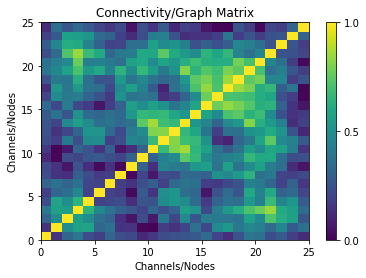

In [ ]:
def generate_graph(n_nodes, regularity=0.1):
  # start with a random matrix
  matrix = np.random.rand(n_nodes, n_nodes)

  # make funny patterns:
  for i in range(n_nodes):
    for ii in range(n_nodes):
      if matrix[i, ii] > matrix[i - 3, ii - 13]:
        matrix[i-2:i+2, ii-2:ii+2] += regularity

  # normalize it from 0 to 0.95, as we shouldn't assume that independet signals are perfectly connected.
  matrix /= np.max(matrix) / 0.95

  # make it look like a connectivity matrix
  for i in range(n_nodes):
    for ii in range(n_nodes):
      # mirror it
      matrix[ii, i] = matrix[i,ii]

      # make the diagonal perfectly connected
      if i == ii:
        matrix[i, ii] = 1

  return matrix

def plot_graph(graph_matrix, title="Connectivity/Graph Matrix"):
  plt.pcolormesh(graph_matrix, vmin=0, vmax=1)
  plt.title(title)
  plt.ylabel('Channels/Nodes')
  plt.xlabel('Channels/Nodes')
  plt.colorbar(ticks=[0, .5, 1])
  plt.show()

plot_graph(generate_graph(n_nodes=25, regularity=0.15))

## Define the graph measures needed for small worldness

If not stated otherwise, all formulas are taken from:

Rubinov & Sporns (2010). Complex network measures of brain connectivity: Uses and interpretations

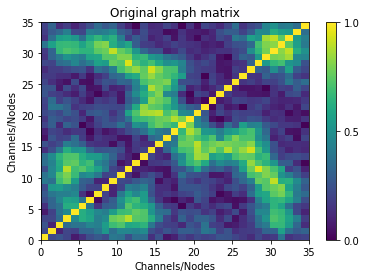

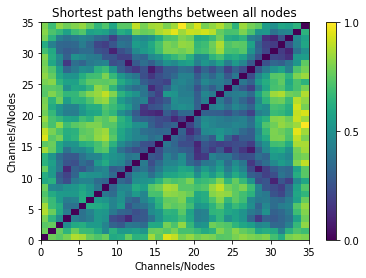

In [ ]:
def weighted_shortest_path(matrix):
  """
  Calculate the shortest path lengths between all nodes in a weighted graph.

  This is an implementation of the Floyd-Warshall algorithm for finding the shortest
  path lengths of an entire graph matrix. Implementation taken from:
  https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm
  """
  inverse_mapping = np.max(matrix) - matrix

  n_nodes = len(matrix)
  distances = np.empty([n_nodes, n_nodes])
  for i in range(n_nodes):
    for j in range(n_nodes):
      distances[i,j] = inverse_mapping[i, j]
  
  # not sure if we even need this, since the coherences of [i,i] are always 1 and therefore 0 in the inverse mapping
  #for i in range(n_nodes):
  #  distances[i,i] = 0

  for k in range(n_nodes):
    for i in range(n_nodes):
      for j in range(n_nodes):
        if distances[i, j] > distances[i, k] + distances[k, j]:
          distances[i, j] = distances[i, k] + distances[k, j]

  return distances


def weighted_characteristic_path_length(matrix):
  """Calculate the characteristic path length for weighted graphs."""
  n_nodes = len(matrix)
  min_distances = weighted_shortest_path(matrix)

  sum_vector = np.empty(n_nodes)
  for i in range(n_nodes):
    # calculate the inner sum
    sum_vector[i] = (1/(n_nodes-1)) * np.sum([min_distances[i, j] for j in range(n_nodes) if j != i])

  return (1/n_nodes) * np.sum(sum_vector)


def weighted_node_degree(matrix):
  """Calculate the node degree for all nodes in a weighted graph."""
  return np.sum(matrix, axis=-1)


def weighted_triangle_number(matrix):
  """Calculate the weighted geometric mean of triangles around i for all nodes i in a weighted graph."""
  n_nodes = len(matrix)

  mean_vector = np.empty([n_nodes])
  for i in range(n_nodes):
    triangles = np.array([[matrix[i, j] * matrix[i, h] * matrix[j, h] for j in range(n_nodes)] for h in range(n_nodes)])**(1/3)
    mean_vector[i] = (1/2) * np.sum(triangles, axis=(0,1))
  
  return mean_vector


def weighted_clustering_coeff(matrix):
  """Calculate the clustering coefficient for a weighted graph."""
  n = len(matrix)
  t = weighted_triangle_number(matrix)
  k = weighted_node_degree(matrix)  # FIXME: k is denoted by rubinov to be the non weighted k. Can this be right? How to measure non weighted k for weighted graphs?

  return (1/n) * np.sum((2 * t)/(k * (k - 1)))


def weighted_small_world_coeff(matrix):
  """Calculate the weighted small world coefficient of a matrix."""
  n_nodes = len(matrix)
  random_graph = np.random.rand(n_nodes, n_nodes) # uniform random from [0 to 1]
  C = weighted_clustering_coeff(matrix)
  C_rand = weighted_clustering_coeff(random_graph)
  L = weighted_characteristic_path_length(matrix)
  L_rand = weighted_characteristic_path_length(random_graph)

  return (C/C_rand) / (L/L_rand)


# get an intuition for the shortest path length matrix
matrix = generate_graph(n_nodes=35, regularity=0.2)
wsp = weighted_shortest_path(matrix)

plot_graph(matrix, title="Original graph matrix")
plot_graph(wsp, title="Shortest path lengths between all nodes")

## Measure Small-Worldness

Feel free to play around a little bit.

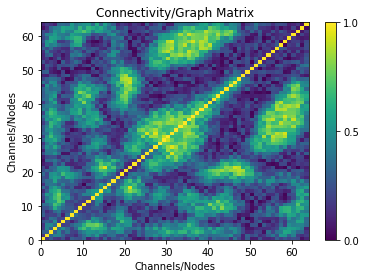

Small worldness coefficient:  0.17842395347129464

Multiple small world measures of the same network graph:

 [0.20874944 0.1804966  0.24569396 0.21756415 0.21662596 0.2114183
 0.2250431  0.19001425 0.21056059 0.22128256]


In [ ]:
# generate a new graph
graph = generate_graph(n_nodes=64, regularity=0.15)

# plot it
plot_graph(graph)


# now we can calculate the small worldness of this one
small_world = weighted_small_world_coeff(graph)
print("Small worldness coefficient: ", small_world)


# actually we can calculate the small worldness multiple times and see how much the random graph affects the outcome.
small_world_list = np.array([weighted_small_world_coeff(graph) for i in range(10)])
print("\nMultiple small world measures of the same network graph:\n\n", small_world_list)

As we can see, the small worldness measure has quite some variance in it. We should probably calculate it multiple times and average!

## Other Graph measures
Define some other graph measures that are interesting.

In [ ]:

def weighted_global_efficiency(matrix):
  """The weighted global efficiency is closely related to the characteristic path length."""
  n_nodes = len(matrix)
  inverse_min_distances = weighted_shortest_path(matrix)

  sum_vector = np.empty(n_nodes)
  for i in range(n_nodes):
    # calculate the inner sum
    sum_vector[i] = (1/(n_nodes-1)) * np.sum([1 / inverse_min_distances[i, j] for j in range(n_nodes) if j != i])

  return (1/n_nodes) * np.sum(sum_vector)


def weighted_transitivity(matrix):
  """The transitivity is related to the clustering coefficient."""
  
  n = len(matrix)
  t = weighted_triangle_number(matrix)
  k = weighted_node_degree(matrix)  # FIXME: k is denoted by rubinov to be the non weighted k. Can this be right? How to measure non weighted k for weighted graphs?
  
  return np.sum(2 * t) / np.sum(k * (k - 1))


## Compare Small-World coefficient with other graph measures
Calculate all interesting measures on a set of graphs and check their correlation.

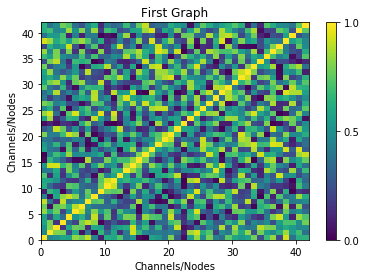

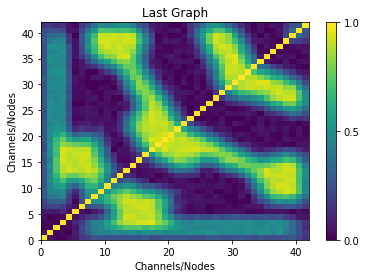

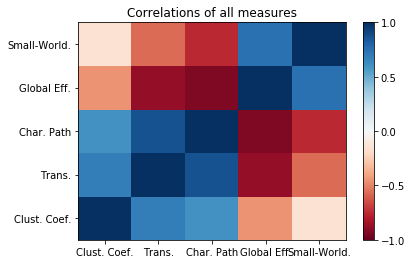

[[ 1.          0.69425749  0.60325383 -0.45310788 -0.15109589]
 [ 0.69425749  1.          0.87405982 -0.87562431 -0.56371736]
 [ 0.60325383  0.87405982  1.         -0.93426057 -0.75179489]
 [-0.45310788 -0.87562431 -0.93426057  1.          0.74278886]
 [-0.15109589 -0.56371736 -0.75179489  0.74278886  1.        ]]


In [ ]:
# first generate multiple graphs to compare
graphs = [generate_graph(n_nodes=42, regularity=0.03*i) for i in range(30)]

# plot some of them
plot_graph(graphs[0], "First Graph")
plot_graph(graphs[-1], "Last Graph")


# calculate different graph measures
clustering_coeffs =     [weighted_clustering_coeff(graph) for graph in graphs]
transitivities =        [weighted_transitivity(graph) for graph in graphs]
characteristic_paths =  [weighted_characteristic_path_length(graph) for graph in graphs]
global_efficiencies =   [weighted_global_efficiency(graph) for graph in graphs]
small_worldness =       [weighted_small_world_coeff(graph) for graph in graphs]


# concatenate them and put them into a correlation matrix
measures = np.vstack([clustering_coeffs, transitivities, characteristic_paths,
                      global_efficiencies, small_worldness])
corr_matrix = np.corrcoef(measures)


# plot the results
plt.pcolormesh(corr_matrix, vmin=-1, vmax=1, cmap="RdBu")
plt.title("Correlations of all measures")
labels = ["Clust. Coef.", "Trans.", "Char. Path", "Global Eff.", "Small-World."]
ax = plt.gca()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(np.arange(5)+0.5)
plt.yticks(np.arange(5)+0.5)
plt.colorbar(ticks=[-1, -.5, 0, .5, 1])
plt.show()

# also print the numbers
print(corr_matrix)

